In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

## Computing Drivatives by Approximation

In [56]:
def f(a,b):
    return a**2 + b

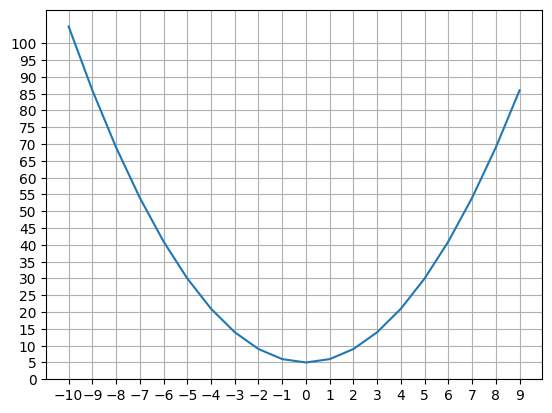

In [20]:
a = list(range(-10, 10))
b = 5
y = [f(x, b) for x in a]
plt.plot(a, y)
plt.xticks(a)
plt.yticks(range(0, max(y), 5))
plt.grid();

**Derivative Approximation**

$df/dx= f(x + h) - f(x) / h$

In [86]:
a = 3
b = 5
h = 0.0000001

df_da = (f(a+h, b) - f(a,b)) / h
df_da

6.000000087880153

## TensorFlow AutoDiff Module

In [105]:
a = tf.Variable(3.0)
b = tf.Variable(5.0)

with tf.autodiff.GradientTape() as tape:
    y = f(a,b)

print(tape.gradient(y, a).numpy())

6.0


In [97]:
a = tf.Variable(3.0)
b = tf.Variable(5.0)

with tf.autodiff.GradientTape() as tape:
    z = f(a,b)
    y = z ** 2

print(tape.gradient(y, [a,b]))

[<tf.Tensor: shape=(), dtype=float32, numpy=168.0>, <tf.Tensor: shape=(), dtype=float32, numpy=28.0>]


- *What do we need?:* $dy/da$
- *Chain Rule:* $dy/da = dy/dz * dz/da$
- $a=3, z=14 $
- $ dy/dz = 2*z=28 , dz/da = 2*a=6 $
- $ dy/da = 28*6=168$

In [106]:
## tape will automatically erased if we call gradient(), so next time calling it will raise an error
try:
    print(tape.gradient(y, [a,b]))
except:
    print("some tensorflow blah blah")

some tensorflow blah blah


In [102]:
## In order to call gradient() multiple times, we need to make gradient tape persistence

with tf.GradientTape(persistent=True) as tape:
    z = f(a,b)

print(tape.gradient(z, a))
print(tape.gradient(z, b))
del tape

tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


In [117]:
## If we need to to watch ops on some non-variable tensor, we can watch them inside tape
a = tf.constant(3.0)
b = tf.constant(5.0)

with tf.GradientTape() as tape:
    tape.watch(a)
    tape.watch(b)
    y = f(a,b)
    
print(tape.gradient(y, a))

tf.Tensor(6.0, shape=(), dtype=float32)


In [70]:
## if we have multiple losses, TF automatically compute sum of losses w.r.t that parameter we want.
## to do seprate derivatives of losses regart to param, we can use jacobian

with tf.GradientTape() as g:
  x  = tf.constant([1.0, 2.0])
  g.watch(x)
  y = x ** 2

print(g.jacobian(y, x))

tf.Tensor(
[[2. 0.]
 [0. 4.]], shape=(2, 2), dtype=float32)


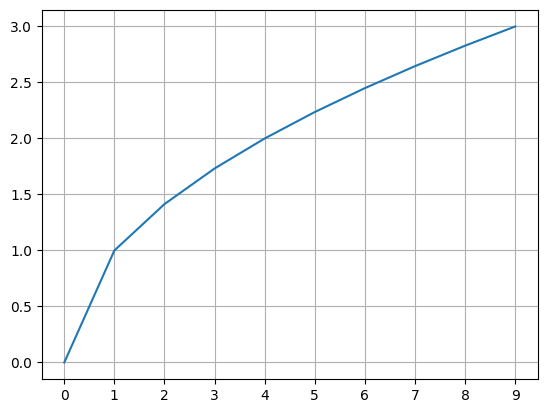

In [54]:
sqrt = (lambda x: pow(x, 0.5))
x = list(range(10))
y = [sqrt(i) for i in x]

plt.plot(x,y)
plt.xticks(x)
plt.grid();

In [49]:
## sqrt gradient at 1e-50 is inf, cause of float32 limit. to overcome, we can add a tiny amount like 1e-6 to x
x = tf.Variable(1e-50)

with tf.GradientTape(persistent=True) as tape:
    y = sqrt(x)
    z = sqrt(x + 1e-6)

print(tape.gradient(y, x).numpy(), " | ", tape.gradient(z, x).numpy())
del tape

inf  |  500.0


## Custom Training Loop

In [400]:
## lets use one of sklearn toy datasets
from sklearn.datasets import load_diabetes
X,y = load_diabetes(return_X_y=True)
print(X.shape, y.shape)

(442, 10) (442,)


In [401]:
def batched_indexes(train_len, batch_size):
    idxs = tf.random.shuffle(range(train_len))
    return [idxs[i:i+batch_size] for i in range(0, train_len, batch_size)]

In [402]:
n_epochs = 25
batch_size = 32
train_len = len(X)

loss_fn = tf.keras.losses.mse
optimizer = tf.keras.optimizers.SGD(0.01)
metric_fn = tf.keras.metrics.mae

model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="linear")
])

In [403]:
for epoch in range(1, n_epochs+1):
    loss_ls, metric_ls = [], []
    shuffled_idx = batched_indexes(train_len, batch_size)
    for step, idx in enumerate(shuffled_idx):
        X_batch, y_batch = X[idx] ,y[idx]
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True) # using model as function by default is not in training mode. (e.g. dropout off)
            loss = tf.reduce_mean(loss_fn(y_pred, y_batch)) # loss_fn return loss for each sample
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        metric = tf.reduce_mean(metric_fn(y_pred,y_batch))
        loss_ls.append(loss)
        metric_ls.append(metric)
    print(f"epoch {epoch} | loss: {tf.reduce_mean(loss_ls)} | metric: {tf.reduce_mean(metric)}")

epoch 1| loss: 22533.259605473162 | metric: 102.20763441232535
epoch 2| loss: 17830.005452135014 | metric: 96.08541283240685
epoch 3| loss: 12699.663649927754 | metric: 90.26039123535156
epoch 4| loss: 9752.68990384917 | metric: 67.0118889441857
epoch 5| loss: 8102.160160040171 | metric: 67.76153388390175
epoch 6| loss: 7172.330158394484 | metric: 72.06779421292819
epoch 7| loss: 6612.721545287961 | metric: 60.17452768179086
epoch 8| loss: 6337.454911227821 | metric: 71.89950561523438
epoch 9| loss: 6187.30284598576 | metric: 77.57692307692308
epoch 10| loss: 6075.450856043287 | metric: 63.07692307692308
epoch 11| loss: 6002.653856570306 | metric: 63.533862774188705
epoch 12| loss: 5966.60217368784 | metric: 60.22980675330529
epoch 13| loss: 5987.006302858787 | metric: 78.33127535306491
epoch 14| loss: 5940.863561827814 | metric: 63.11538461538461
epoch 15| loss: 5936.437880325468 | metric: 62.07692307692308
epoch 16| loss: 5935.757035619309 | metric: 64.44571157602164
epoch 17| loss: 